# Wild Blueberry Yield Prediction

## Importing the required Libraries

In [25]:
# Importing general libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import shap

#Feature enginerring libraries
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression, mutual_info_regression
from sklearn.model_selection import train_test_split

#Model preparation libraries
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import RepeatedKFold

#Model evaluation libraries
from sklearn import metrics
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error

#Model hyperparameter tuning
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

#Additional imports

import joblib
%matplotlib inline



# Importing Data and Preprocessing


According to data dictionary, we have 3 unknown fields, <b>fruitset, fruitmass, seeds</b> having high correlation values with the target varialble, the <b>yield</b> value.

1. we have a data dictionary of mutual correlated values of each of the fields with yield values
2. as this clearly is a regression problem, we can perform feature selection on the data
3. there are the following approaches:
    * f_regression() parameter for selecting by correlation
    * mutual_info_regression() for selecting by information gain
    * raw data features kept intact

In [8]:
#Loading the Data
berry_data = pd.read_csv(r"D:\Wild_Blueberry_Yield_Prediction\src\data\WildBlueberryPollinationSimulationData.csv")

#Printing 25 rows
print(berry_data.head(20))

    Row#  clonesize  honeybee  bumbles  andrena  osmia  MaxOfUpperTRange   
0      0       37.5      0.75     0.25     0.25   0.25              86.0  \
1      1       37.5      0.75     0.25     0.25   0.25              86.0   
2      2       37.5      0.75     0.25     0.25   0.25              94.6   
3      3       37.5      0.75     0.25     0.25   0.25              94.6   
4      4       37.5      0.75     0.25     0.25   0.25              86.0   
5      5       37.5      0.75     0.25     0.25   0.25              86.0   
6      6       37.5      0.75     0.25     0.25   0.25              94.6   
7      7       37.5      0.75     0.25     0.25   0.25              94.6   
8      8       37.5      0.75     0.25     0.25   0.25              77.4   
9      9       37.5      0.75     0.25     0.25   0.25              77.4   
10    10       37.5      0.75     0.25     0.25   0.25              69.7   
11    11       37.5      0.25     0.25     0.25   0.25              86.0   
12    12    

In [9]:
#Checking for metadata
print(berry_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 777 entries, 0 to 776
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Row#                  777 non-null    int64  
 1   clonesize             777 non-null    float64
 2   honeybee              777 non-null    float64
 3   bumbles               777 non-null    float64
 4   andrena               777 non-null    float64
 5   osmia                 777 non-null    float64
 6   MaxOfUpperTRange      777 non-null    float64
 7   MinOfUpperTRange      777 non-null    float64
 8   AverageOfUpperTRange  777 non-null    float64
 9   MaxOfLowerTRange      777 non-null    float64
 10  MinOfLowerTRange      777 non-null    float64
 11  AverageOfLowerTRange  777 non-null    float64
 12  RainingDays           777 non-null    float64
 13  AverageRainingDays    777 non-null    float64
 14  fruitset              777 non-null    float64
 15  fruitmass             7

#### Observations-
##### 1)The dataframe has a total of 777 entries (rows) and 18 columns.
##### 2)The data types of the columns are mostly float64 (17      columns) and one column is of type int64 ("Row#").
##### 3)All columns have a non-null count of 777, indicating that there are no missing values in the dataframe.
##### 4)The memory usage of the dataframe is approximately 109.4 KB.

In [17]:
#Checking for Null values
print(berry_data.isna().sum().sort_values(ascending=False))

Row#                    0
clonesize               0
seeds                   0
fruitmass               0
fruitset                0
AverageRainingDays      0
RainingDays             0
AverageOfLowerTRange    0
MinOfLowerTRange        0
MaxOfLowerTRange        0
AverageOfUpperTRange    0
MinOfUpperTRange        0
MaxOfUpperTRange        0
osmia                   0
andrena                 0
bumbles                 0
honeybee                0
yield                   0
dtype: int64


In [16]:
#Checking for duplicates
print(berry_data.duplicated().sort_values(ascending=False))

0      False
534    False
512    False
513    False
514    False
       ...  
262    False
263    False
264    False
265    False
776    False
Length: 777, dtype: bool


In [13]:
#Checking for Stats description
print(berry_data.describe(include='all'))

             Row#   clonesize    honeybee     bumbles     andrena       osmia   
count  777.000000  777.000000  777.000000  777.000000  777.000000  777.000000  \
mean   388.000000   18.767696    0.417133    0.282389    0.468817    0.562062   
std    224.444871    6.999063    0.978904    0.066343    0.161052    0.169119   
min      0.000000   10.000000    0.000000    0.000000    0.000000    0.000000   
25%    194.000000   12.500000    0.250000    0.250000    0.380000    0.500000   
50%    388.000000   12.500000    0.250000    0.250000    0.500000    0.630000   
75%    582.000000   25.000000    0.500000    0.380000    0.630000    0.750000   
max    776.000000   40.000000   18.430000    0.585000    0.750000    0.750000   

       MaxOfUpperTRange  MinOfUpperTRange  AverageOfUpperTRange   
count        777.000000        777.000000            777.000000  \
mean          82.277091         49.700515             68.723037   
std            9.193745          5.595769              7.676984   
mi

In [14]:
#Checking for unique values
print(berry_data.nunique().sort_values(ascending=False))

Row#                    777
fruitset                777
seeds                   777
fruitmass               777
yield                   777
osmia                    12
andrena                  12
bumbles                  10
honeybee                  7
clonesize                 6
MaxOfUpperTRange          5
MinOfUpperTRange          5
AverageOfUpperTRange      5
MinOfLowerTRange          5
AverageOfLowerTRange      5
RainingDays               5
AverageRainingDays        5
MaxOfLowerTRange          5
dtype: int64


# Univariate Analysis

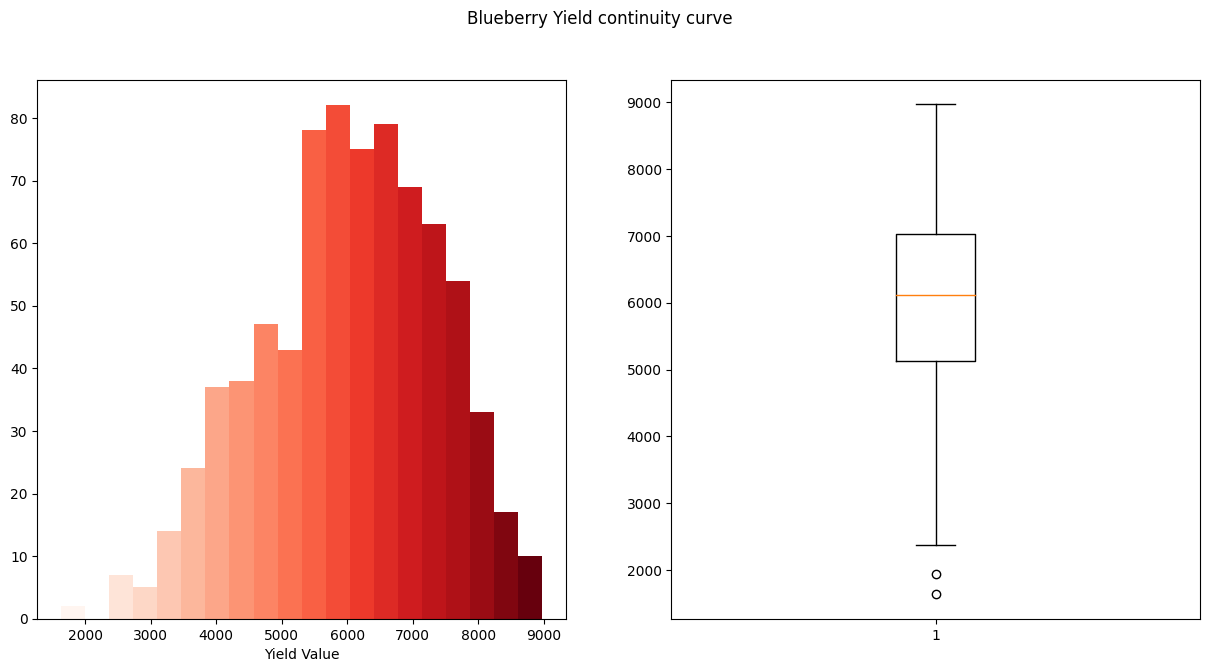

In [37]:
#Analysis


figs, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))
figs.suptitle("Blueberry Yield continuity curve")

# Histogram plot
x = berry_data["yield"]
n, bins, patches = ax1.hist(x, bins=20, color="salmon")

# Calculate gradient values
gradient = np.linspace(0, 1, len(patches))
for patch, color in zip(patches, gradient):
    patch.set_facecolor(plt.cm.Reds(color))

ax1.set_xlabel("Yield Value")

# Boxplot plot
ax2.boxplot(x)
vis_path =r"D:\Wild_Blueberry_Yield_Prediction\src\visualizations\Blueberry_Yield_continuity_curve.png"
plt.savefig(vis_path)
plt.show()
#Saving the figure


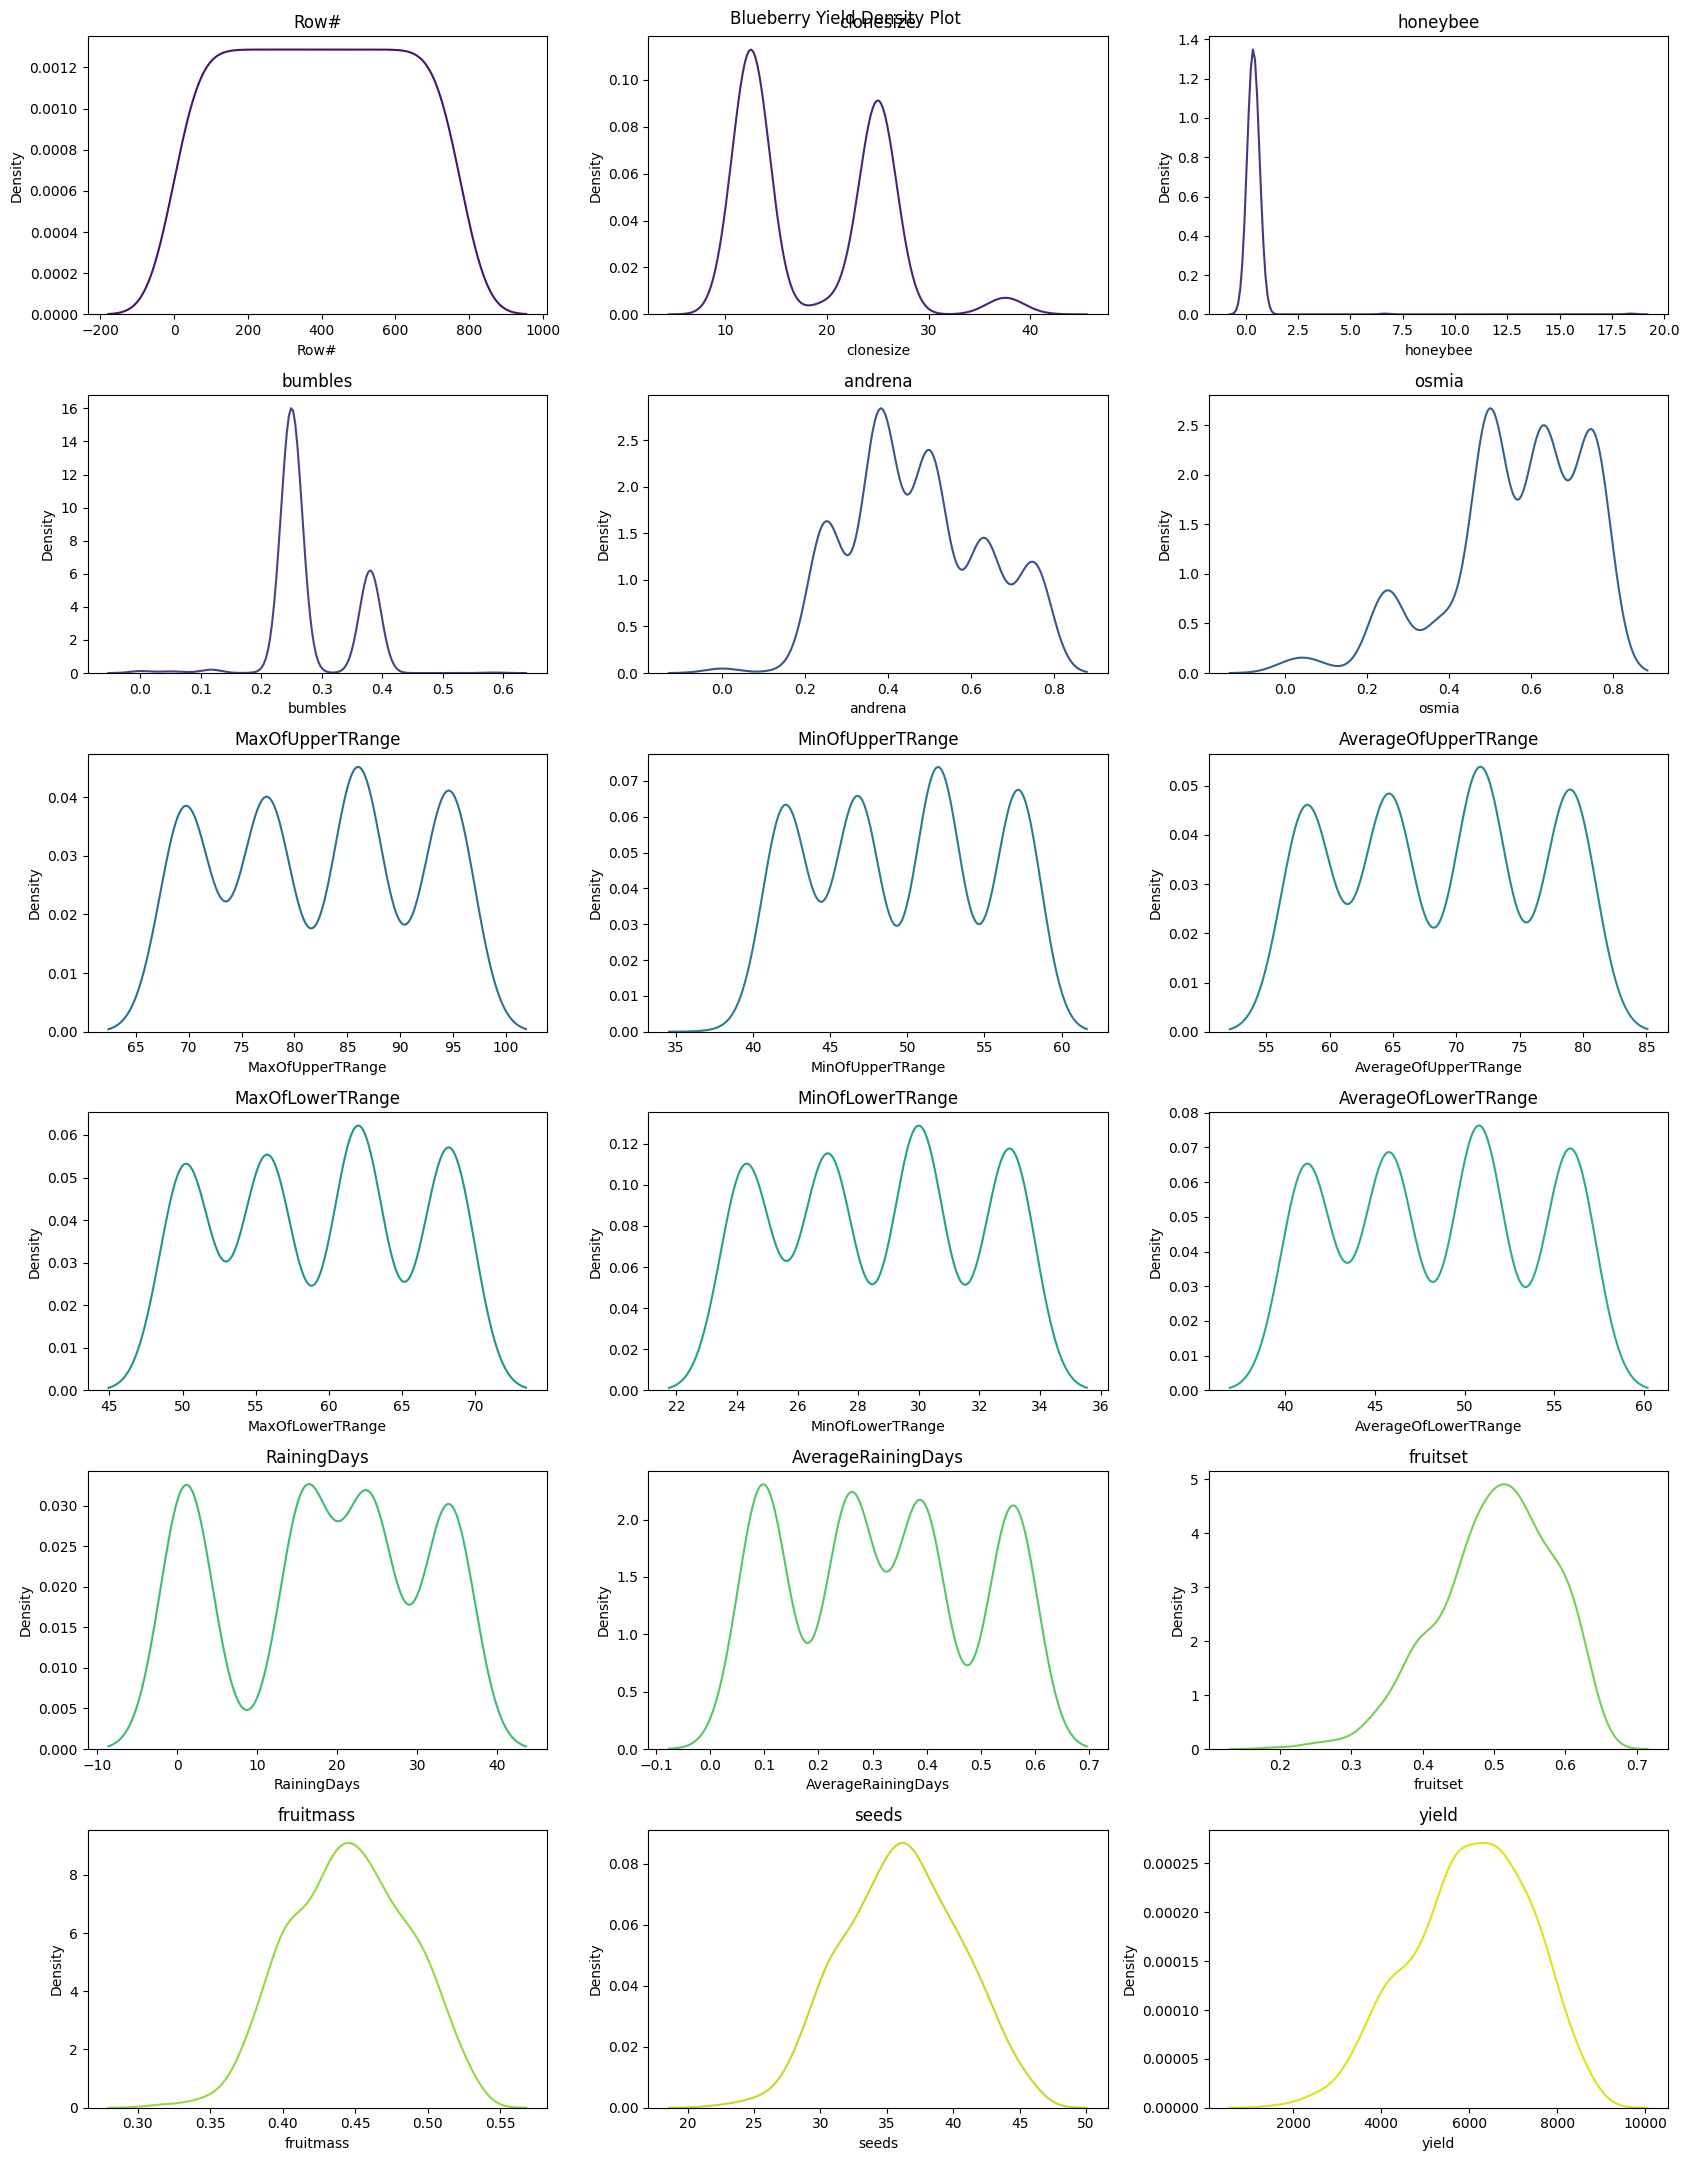

In [38]:
 #Density Plot
colors = sns.color_palette("viridis", len(berry_data.columns))

# Density plot
fig, axes = plt.subplots(6, 3, figsize=(17, 22))
fig.suptitle("Blueberry Yield Density Plot")

for i, (col, ax) in enumerate(zip(berry_data.columns, axes.flatten())):
    sns.kdeplot(data=berry_data, x=col, color=colors[i], ax=ax)
    ax.set_title(col)


vis_path2 =r"D:\Wild_Blueberry_Yield_Prediction\src\visualizations\Blueberry_Yield_Density_Plot.png"
plt.savefig(vis_path2)
plt.tight_layout()
plt.show()

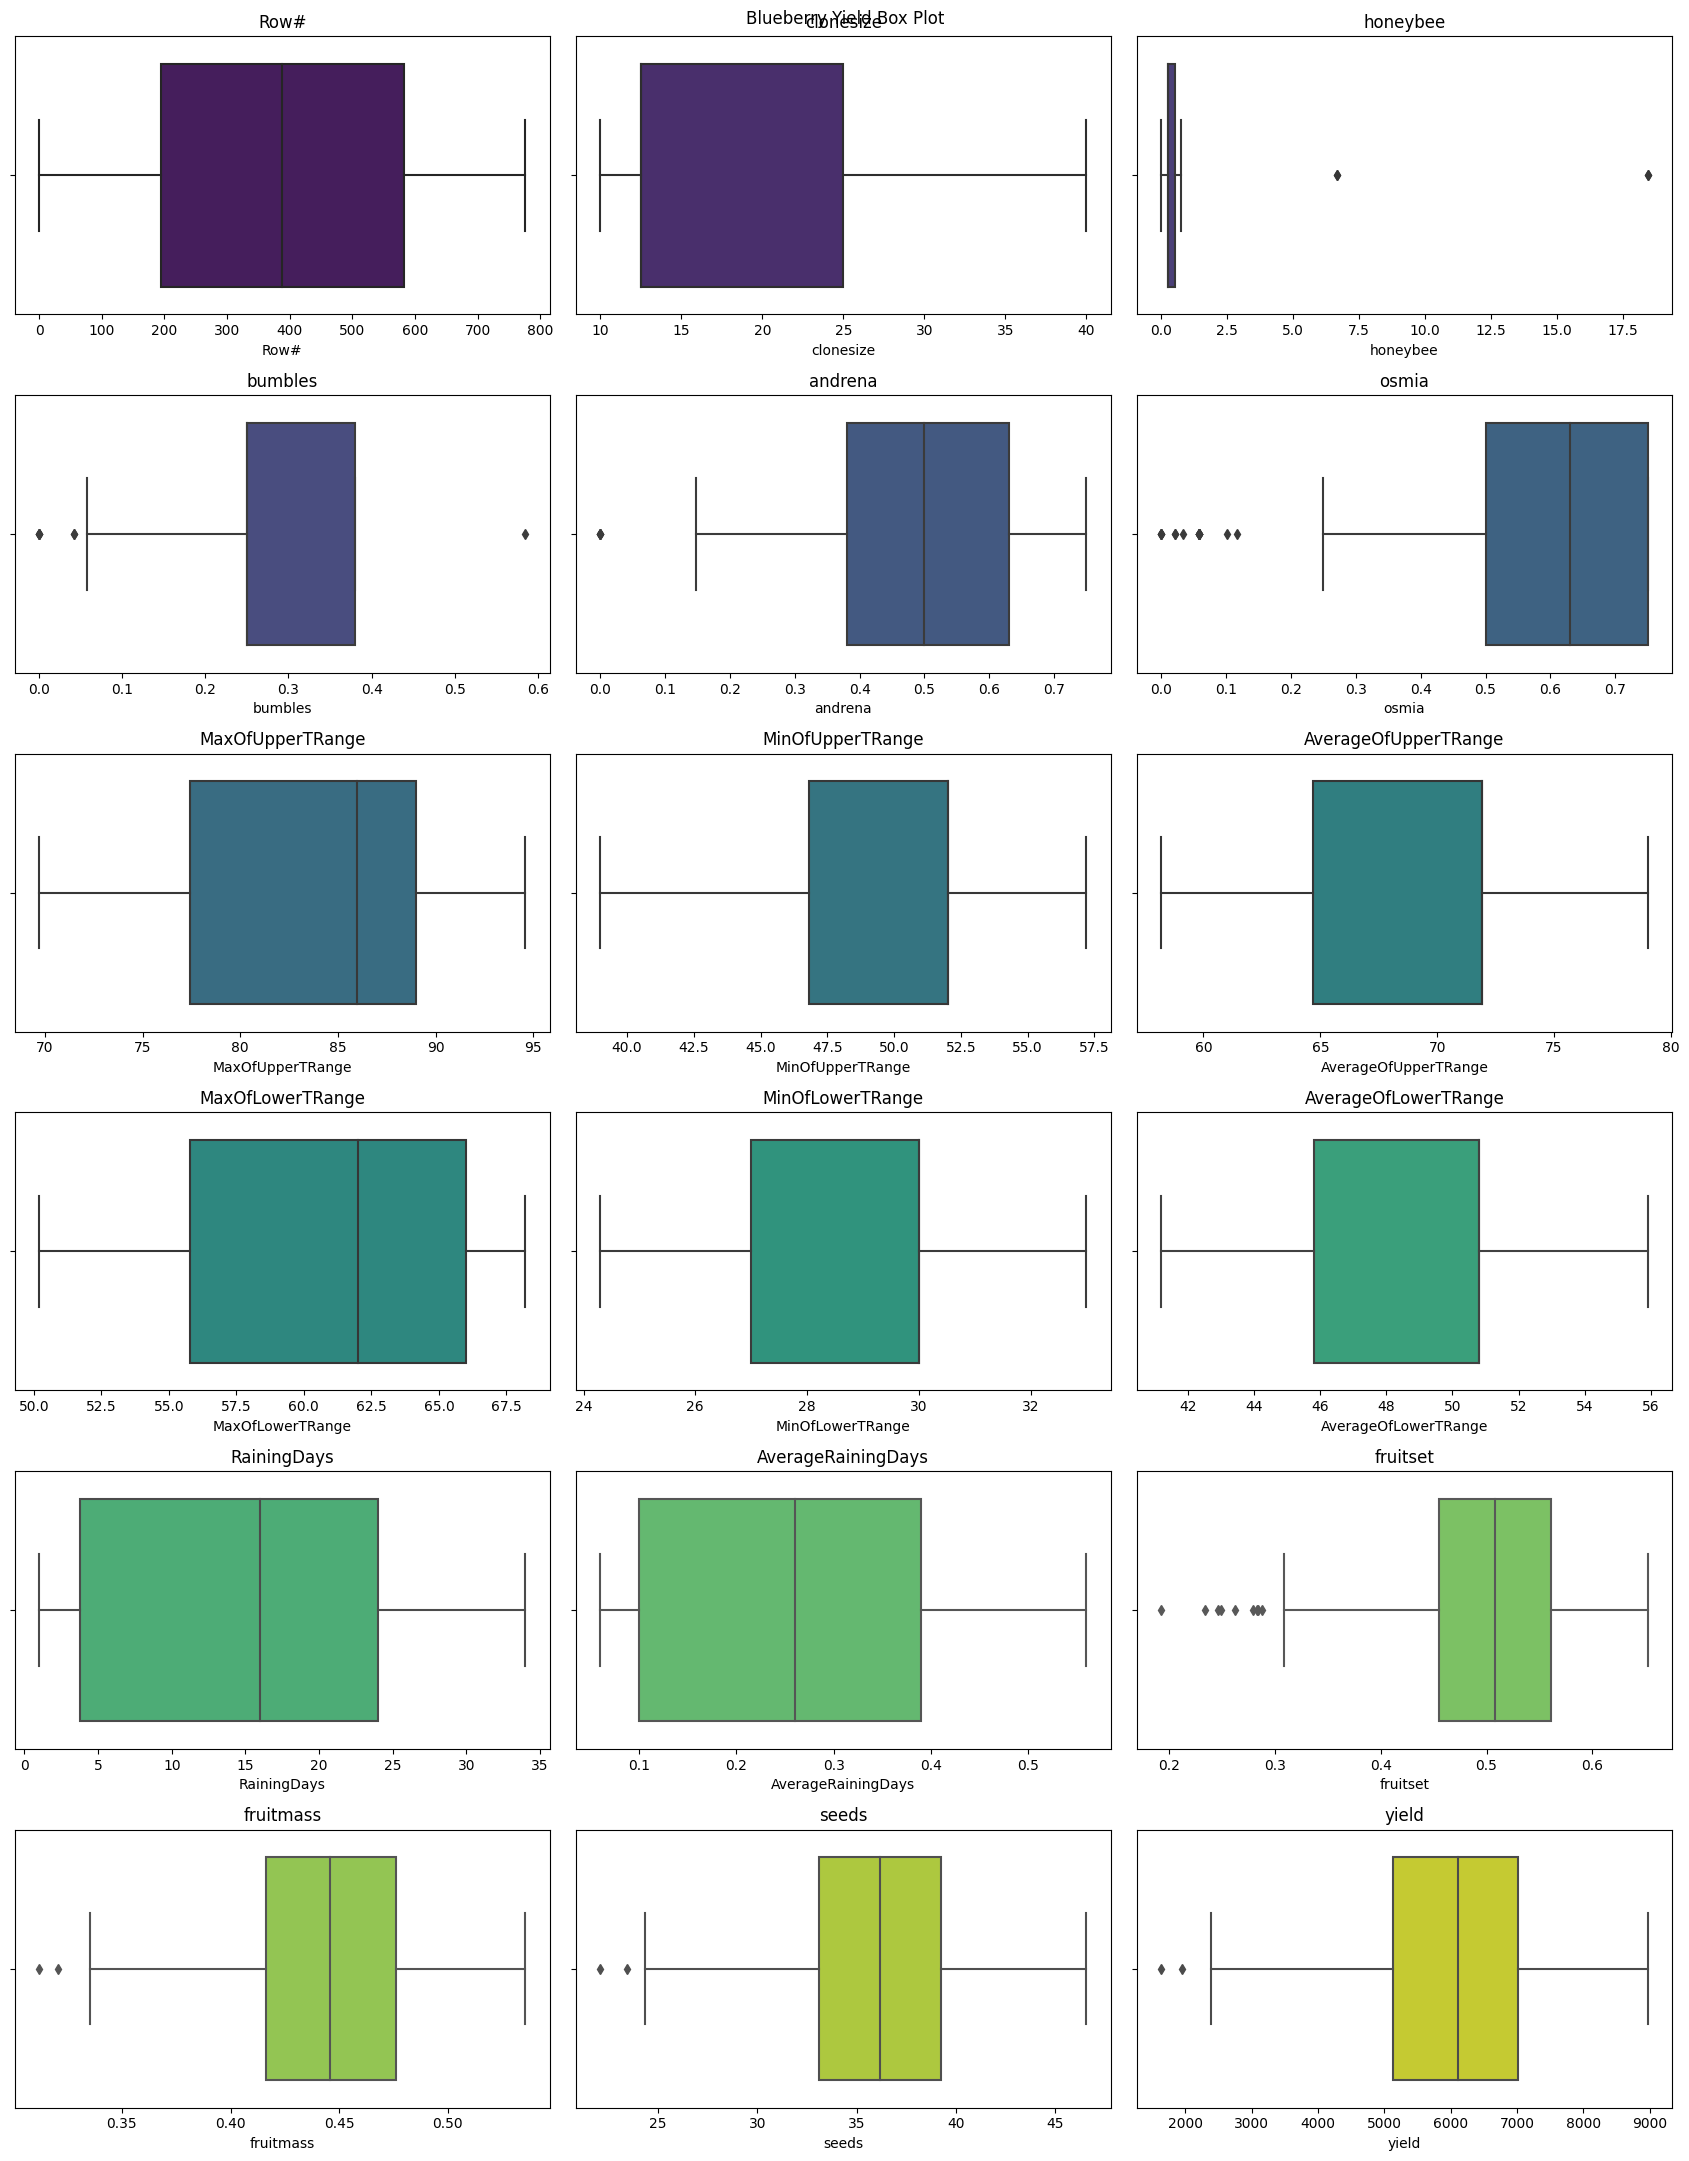

In [39]:
 #Density Plot
colors = sns.color_palette("viridis", len(berry_data.columns))

# Density plot
fig, axes = plt.subplots(6, 3, figsize=(17, 22))
fig.suptitle("Blueberry Yield Box Plot")

for i, (col, ax) in enumerate(zip(berry_data.columns, axes.flatten())):
    sns.boxplot(data=berry_data, x=col, color=colors[i], ax=ax)
    ax.set_title(col)


vis_path3 =r"D:\Wild_Blueberry_Yield_Prediction\src\visualizations\Blueberry_Yield_Box_Plot.png"
plt.savefig(vis_path3)
plt.tight_layout()
plt.show()

# Multivariate Analysis

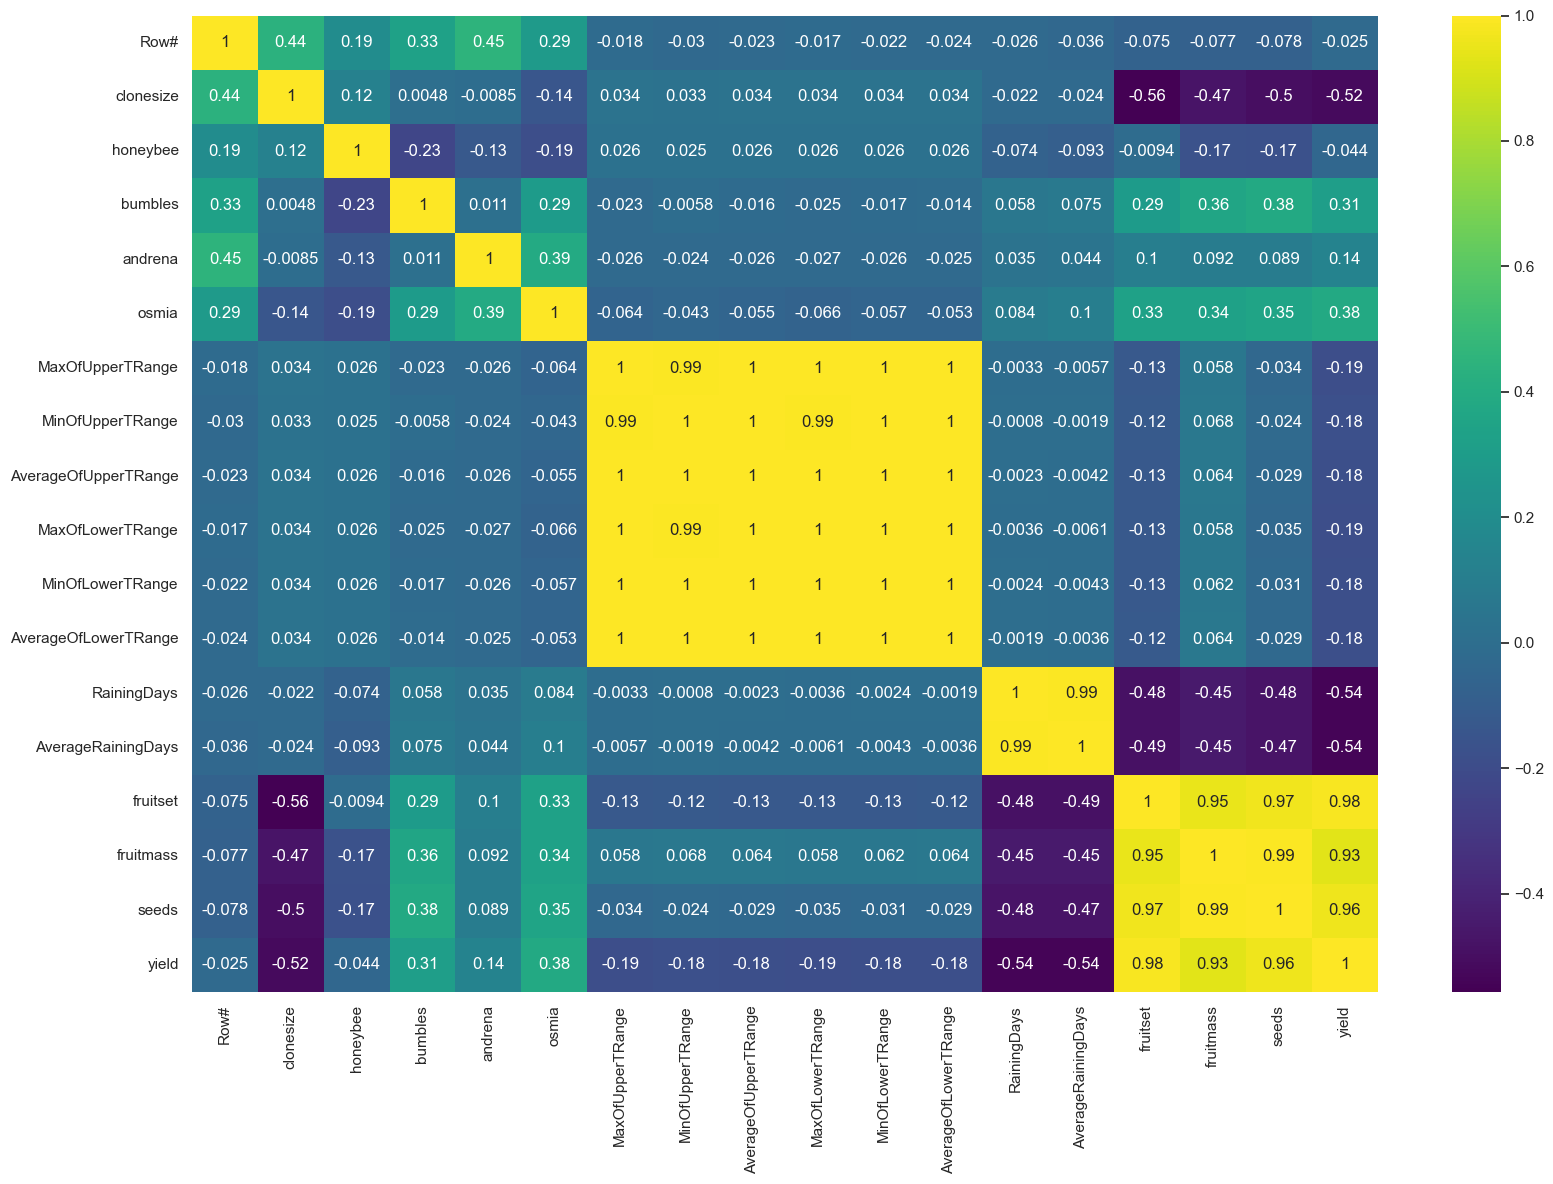

In [41]:
#Heatmap
plt.figure(figsize=(17,12))
sns.set()
sns.heatmap(berry_data.corr(), annot=True, cmap="viridis")

vis_path4 =r"D:\Wild_Blueberry_Yield_Prediction\src\visualizations\Heatmap.png"
plt.savefig(vis_path4)
plt.tight_layout()
plt.show()

# Preprocessing

columns to drop: 'Row#', 'MaxOfUpperTRange', 'MinOfUpperTRange', 'MaxOfLowerTRange', 'MinOfLowerTRange', 'RainingDays', 'honeybee'

We cannot keep fruitmass, fruitset and seeds as well. they are the derivatives of the output and cannot be considered for training.

In [42]:
#Checking columns name 
berry_data.columns


Index(['Row#', 'clonesize', 'honeybee', 'bumbles', 'andrena', 'osmia',
       'MaxOfUpperTRange', 'MinOfUpperTRange', 'AverageOfUpperTRange',
       'MaxOfLowerTRange', 'MinOfLowerTRange', 'AverageOfLowerTRange',
       'RainingDays', 'AverageRainingDays', 'fruitset', 'fruitmass', 'seeds',
       'yield'],
      dtype='object')

In [43]:
#Dropping columns
bbry_data_process = berry_data.drop(columns=['Row#', 'MaxOfUpperTRange', 'MinOfUpperTRange', 'MaxOfLowerTRange', 'MinOfLowerTRange', 'RainingDays', 'honeybee', "fruitset", "fruitmass", "seeds"])
bbry_data_process

,clonesize,bumbles,andrena,osmia,AverageOfUpperTRange,AverageOfLowerTRange,AverageRainingDays,yield
0,37.5,0.250,0.250,0.250,71.9,50.8,0.26,3813.165795
1,37.5,0.250,0.250,0.250,71.9,50.8,0.10,4947.605663
2,37.5,0.250,0.250,0.250,79.0,55.9,0.26,3866.798965
3,37.5,0.250,0.250,0.250,79.0,55.9,0.10,4303.943030
4,37.5,0.250,0.250,0.250,71.9,50.8,0.39,3436.493543
...,...,...,...,...,...,...,...,...
772,10.0,0.117,0.409,0.058,71.9,50.8,0.06,5333.873335
773,40.0,0.117,0.409,0.058,71.9,50.8,0.06,3373.436842
774,20.0,0.117,0.409,0.058,71.9,50.8,0.39,4203.027624
775,20.0,0.117,0.409,0.058,65.6,45.3,0.06,4166.299735


In [44]:
#Splitting into input and target variables
part1 = bbry_data_process.drop(columns=['yield'])
part2 = bbry_data_process[['yield']]
part1

,clonesize,bumbles,andrena,osmia,AverageOfUpperTRange,AverageOfLowerTRange,AverageRainingDays
0,37.5,0.250,0.250,0.250,71.9,50.8,0.26
1,37.5,0.250,0.250,0.250,71.9,50.8,0.10
2,37.5,0.250,0.250,0.250,79.0,55.9,0.26
3,37.5,0.250,0.250,0.250,79.0,55.9,0.10
4,37.5,0.250,0.250,0.250,71.9,50.8,0.39
...,...,...,...,...,...,...,...
772,10.0,0.117,0.409,0.058,71.9,50.8,0.06
773,40.0,0.117,0.409,0.058,71.9,50.8,0.06
774,20.0,0.117,0.409,0.058,71.9,50.8,0.39
775,20.0,0.117,0.409,0.058,65.6,45.3,0.06


In [46]:
#Checking for IQR
Q1 = part1.quantile(0.25)
Q3 = part1.quantile(0.75)
IQR = Q3 - Q1
print(IQR)

clonesize               12.50
bumbles                  0.13
andrena                  0.25
osmia                    0.25
AverageOfUpperTRange     7.20
AverageOfLowerTRange     5.00
AverageRainingDays       0.29
dtype: float64


In [49]:
#Outlier detection and removal
Q1 = bbry_data_process.quantile(0.25)
Q3 = bbry_data_process.quantile(0.75)
IQR = Q3 - Q1

# Filter out rows with outliers
outlier_filter = ~((bbry_data_process < (Q1 - 1.5 * IQR)) | (bbry_data_process > (Q3 + 1.5 * IQR))).any(axis=1)
bbry_data_iqr = bbry_data_process[outlier_filter]

# Get the shape of the filtered data
rows, columns = bbry_data_iqr.shape

# Print the shape
print("Filtered Data Shape:", rows, "rows and", columns, "columns")

Filtered Data Shape: 758 rows and 8 columns


Using the boxplot function without specifying `order` is likely to produce an incorrect plot.


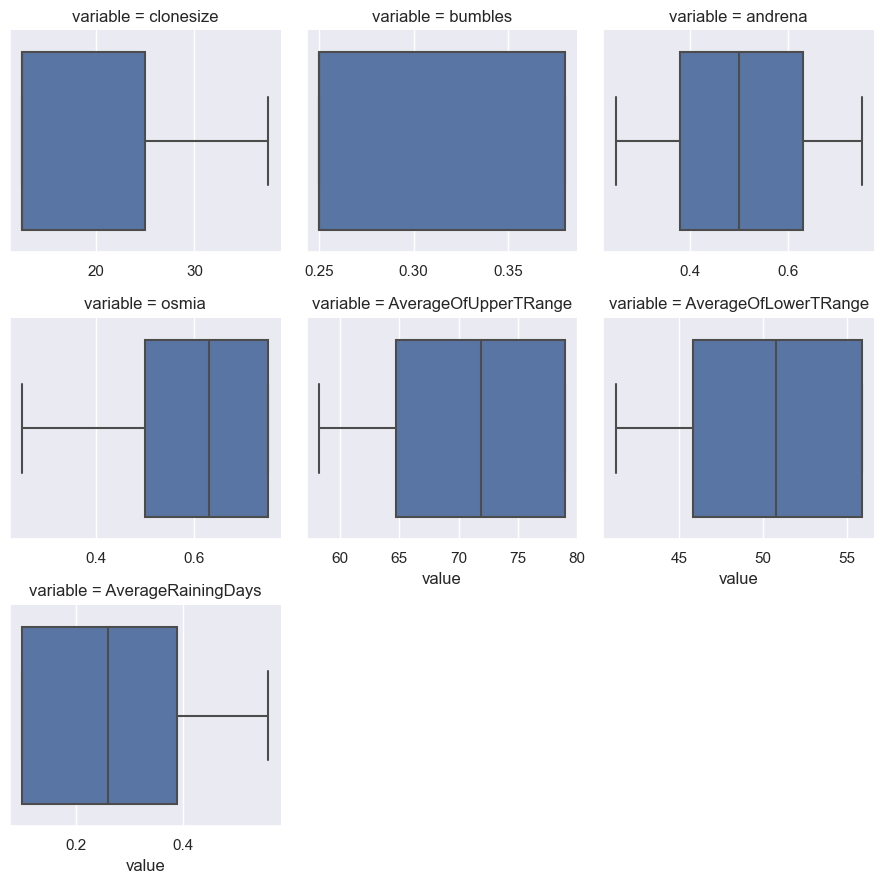

In [54]:
#Data transformation and Visual
unpivot = pd.melt(bbry_data_iqr, bbry_data_iqr.describe().columns[-1], bbry_data_iqr.describe().columns[:-1])

g = sns.FacetGrid(unpivot, col="variable", col_wrap=3, sharex=False, sharey=False)
g.map(sns.boxplot, "value")

plt.show()

In [55]:
#Calculating Z
z = np.abs(stats.zscore(bbry_data_process))
print(z)

     clonesize   bumbles   andrena     osmia  AverageOfUpperTRange   
0     2.678126  0.488512  1.359549  1.846405              0.414096  \
1     2.678126  0.488512  1.359549  1.846405              0.414096   
2     2.678126  0.488512  1.359549  1.846405              1.339534   
3     2.678126  0.488512  1.359549  1.846405              1.339534   
4     2.678126  0.488512  1.359549  1.846405              0.414096   
..         ...       ...       ...       ...                   ...   
772   1.253503  2.494523  0.371655  2.982429              0.414096   
773   3.035546  2.494523  0.371655  2.982429              0.414096   
774   0.176180  2.494523  0.371655  2.982429              0.414096   
775   0.176180  2.494523  0.371655  2.982429              0.407067   
776   0.176180  2.494523  0.371655  2.982429              0.407067   

     AverageOfLowerTRange  AverageRainingDays     yield  
0                0.403960            0.350531  1.622087  
1                0.403960            1.2852

In [56]:
#processing with z<3
bbry_data_zscore = bbry_data_process[(z < 3).all(axis=1)]
bbry_data_zscore.shape

(767, 8)

Using the boxplot function without specifying `order` is likely to produce an incorrect plot.


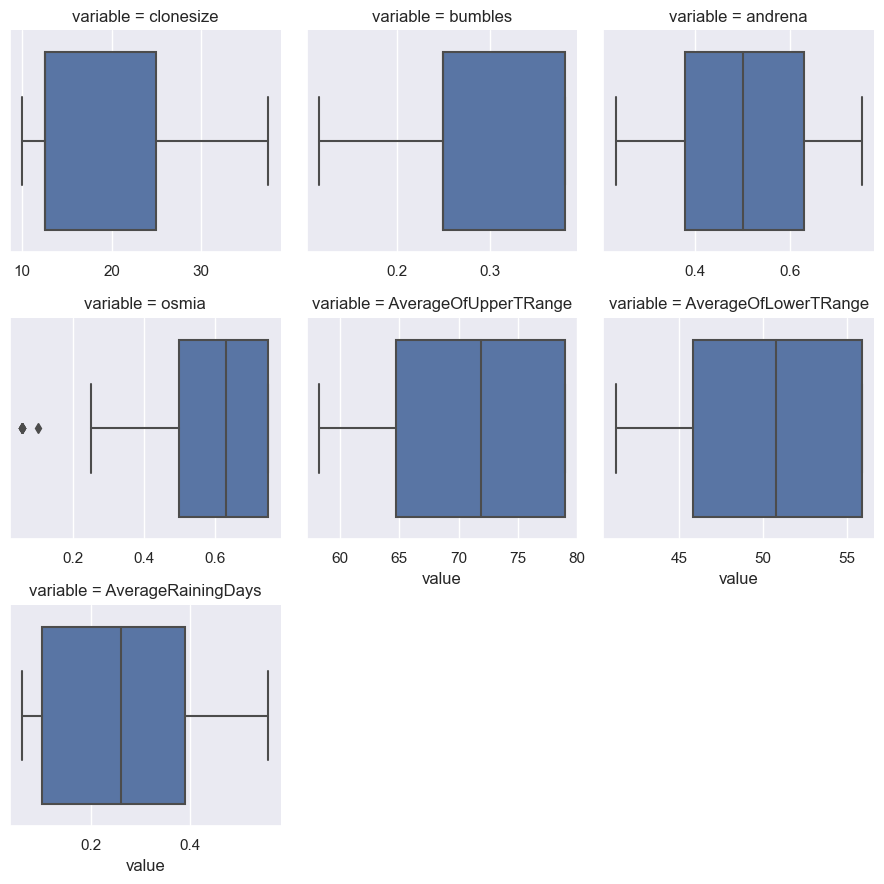

In [57]:
#checking again
unpivot = pd.melt(bbry_data_zscore, bbry_data_zscore.columns[-1], bbry_data_zscore.columns[:-1])

g = sns.FacetGrid(unpivot, col="variable", col_wrap=3, sharex=False, sharey=False)
g.map(sns.boxplot, "value")


plt.show()

In [58]:
bbry_data_process = bbry_data_zscore
bbry_data_process

,clonesize,bumbles,andrena,osmia,AverageOfUpperTRange,AverageOfLowerTRange,AverageRainingDays,yield
0,37.5,0.250,0.250,0.250,71.9,50.8,0.26,3813.165795
1,37.5,0.250,0.250,0.250,71.9,50.8,0.10,4947.605663
2,37.5,0.250,0.250,0.250,79.0,55.9,0.26,3866.798965
3,37.5,0.250,0.250,0.250,79.0,55.9,0.10,4303.943030
4,37.5,0.250,0.250,0.250,71.9,50.8,0.39,3436.493543
...,...,...,...,...,...,...,...,...
770,20.0,0.293,0.234,0.058,71.9,50.8,0.06,5449.421199
772,10.0,0.117,0.409,0.058,71.9,50.8,0.06,5333.873335
774,20.0,0.117,0.409,0.058,71.9,50.8,0.39,4203.027624
775,20.0,0.117,0.409,0.058,65.6,45.3,0.06,4166.299735


# Feature Selection

In [59]:
def select_features_corr_based(X_train, y_train, X_test, x="all"):
    if type(x) == str:
        fs_corr = SelectKBest(score_func=f_regression, k='all')
    else:
        fs_corr = SelectKBest(score_func=f_regression, k = x)
    fs_corr.fit(X_train, y_train)
    X_train_fs = fs_corr.transform(X_train)
    X_test_fs = fs_corr.transform(X_test)
    
    return X_train_fs, X_test_fs, fs_corr

def select_features_infogain_based(X_train, y_train, X_test, x="all"):
    if type(x) == str:
        fs_info = SelectKBest(score_func=mutual_info_regression, k='all')
    else:
        fs_info = SelectKBest(score_func=mutual_info_regression, k=x)
    fs_info.fit(X_train, y_train)
    X_train_fs = fs_info.transform(X_train)
    X_test_fs = fs_info.transform(X_test)
    
    return X_train_fs, X_test_fs, fs_info

In [60]:
#Setting X,y and train and test variables and feature selection
X = bbry_data_process.drop(["yield"], axis=1)
y = bbry_data_process['yield']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)

X_train_fs_corr, X_test_fs_corr, fs_corr = select_features_corr_based(X_train, y_train, X_test)
X_train_fs_info, X_test_fs_info, fs_info = select_features_infogain_based(X_train, y_train, X_test)

#Note:The KSelection score plot describes a good behavior of the Information Gain Values.

Feature clonesize: 197.463675
Feature bumbles: 28.488060
Feature andrena: 7.497100
Feature osmia: 86.995221
Feature AverageOfUpperTRange: 16.802420
Feature AverageOfLowerTRange: 16.641514
Feature AverageRainingDays: 273.072671


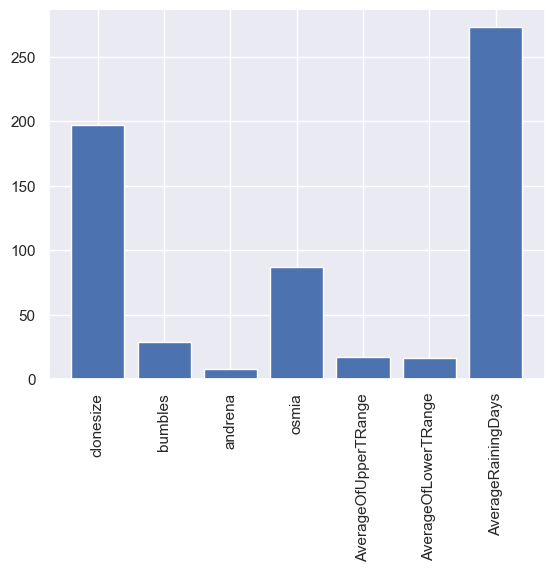

Feature clonesize: 0.164336
Feature bumbles: 0.022046
Feature andrena: 0.046534
Feature osmia: 0.104581
Feature AverageOfUpperTRange: 0.074052
Feature AverageOfLowerTRange: 0.073958
Feature AverageRainingDays: 0.218030


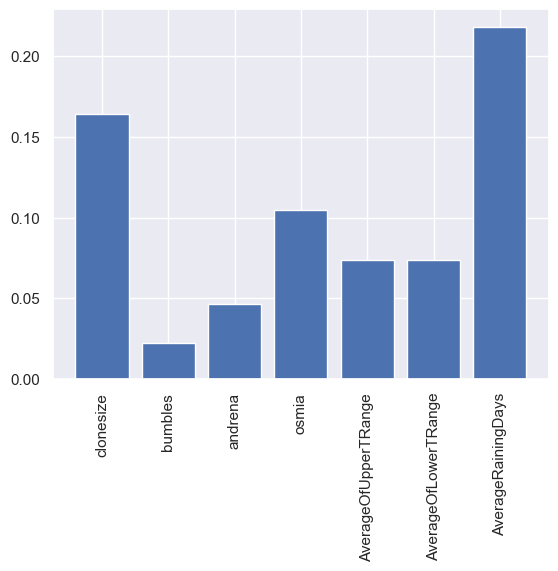

In [61]:
def fs_score_plot(fs_func):
    
    for i in range(len(fs_func.get_feature_names_out())):
        print('Feature %s: %f' % (fs_func.get_feature_names_out()[i], fs_func.scores_[i]))
    # plot the scores
    plt.bar(fs_func.get_feature_names_out(), fs_func.scores_)
    plt.xticks(rotation=90)
    plt.show()
    
fs_score_plot(fs_corr)
fs_score_plot(fs_info)

# Modelling
### Using top 9 features

In [62]:
#Splitting the data
X = bbry_data_process.drop(["yield"], axis=1)
y = bbry_data_process['yield']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)

X_train_fs, X_test_fs, fs_info = select_features_infogain_based(X_train, y_train, X_test, x=7)

# Linear Regression

In [63]:
lreg = LinearRegression()

lreg.fit(X_train_fs, y_train)

yhat = lreg.predict(X_test_fs)

In [64]:
# Evaluating the lreg model
mae_linear = mean_absolute_error(y_test, yhat)
mse_linear = mean_squared_error(y_test, yhat)
rmse_linear = np.sqrt(mse_linear)
rsq_linear = r2_score(y_test, yhat)

print('MAE: %.3f' % mae_linear)
print('MSE: %.3f' % mse_linear)
print('RMSE: %.3f' % rmse_linear)
print('R-Square: %.3f' % rsq_linear)

MAE: 498.588
MSE: 362441.786
RMSE: 602.031
R-Square: 0.804


# RandomForest Regression

In [65]:
rf = RandomForestRegressor()

rf.fit(X_train_fs, y_train)
    
yhat = rf.predict(X_test_fs)

In [66]:
# Evaluating rf
mae_rf = mean_absolute_error(y_test, yhat)
mse_rf = mean_squared_error(y_test, yhat)
rmse_rf = np.sqrt(mse_rf)
rsq_rf = r2_score(y_test, yhat)

print('MAE: %.3f' % mae_rf)
print('MSE: %.3f' % mse_rf)
print('RMSE: %.3f' % rmse_rf)
print('R-Square: %.3f' % rsq_rf)

MAE: 209.186
MSE: 74728.411
RMSE: 273.365
R-Square: 0.960


# Decision Tree Regressior

In [67]:
dtree = DecisionTreeRegressor()

dtree.fit(X_train_fs, y_train)

yhat = dtree.predict(X_test_fs)

In [68]:
#Evaluating dtree
mae_dt = mean_absolute_error(y_test, yhat)
mse_dt = mean_squared_error(y_test, yhat)
rmse_dt = np.sqrt(mse_dt)
rsq_dt = r2_score(y_test, yhat)

print('MAE: %.3f' % mae_dt)
print('MSE: %.3f' % mse_dt)
print('RMSE: %.3f' % rmse_dt)
print('R-Square: %.3f' % rsq_dt)

MAE: 266.031
MSE: 127862.122
RMSE: 357.578
R-Square: 0.931


# XGBRegressor

In [69]:
xgb = XGBRegressor()

xgb.fit(X_train_fs, y_train)

yhat = xgb.predict(X_test_fs)

In [70]:
#Evaluating xgb
mae_xgb = mean_absolute_error(y_test, yhat)
mse_xgb = mean_squared_error(y_test, yhat)
rmse_xgb = np.sqrt(mse_dt)
rsq_xgb = r2_score(y_test, yhat)

print('MAE: %.3f' % mae_xgb)
print('MSE: %.3f' % mse_xgb)
print('RMSE: %.3f' % rmse_xgb)
print('R-Square: %.3f' % rsq_xgb)

MAE: 193.592
MSE: 62385.734
RMSE: 357.578
R-Square: 0.966


# Model Evaluation

#### Note:We can also check the R2 score. Here, we will be aiming to reduce the RMSE and MAE values. The comparative BarPlot shows the values of each. We have Linear Regression (150.309) and XGBoost (145.976) at the lowest Error Rate